In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !pip install albumentations
!pip install segmentation-models-pytorch

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 163kB 7.3MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=4d43522d7da3ee07928d5b3a4fe266755f9f988362f4698056fd81336db78070
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=1ecb8c802120b199c5ee11e9014107ddcbdab1f41a4f3cf1a32654857a9ad9cf
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [72]:
%cd /content/drive/My Drive/Colab Notebooks/Gasprom-Challange/notebooks

/content/drive/My Drive/Colab Notebooks/Gasprom-Challange/notebooks


In [6]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt 
import albumentations as albu

from torch.utils.data import DataLoader, Dataset as BaseDataset
from pathlib import Path

In [7]:
np.random.seed(0)

# load the data
datapath = Path.cwd().parent / 'data'
data_train = np.load(datapath/'data_train.npz', allow_pickle=True, mmap_mode='r')
data_train = data_train['data']

labels_train = np.load(datapath/'labels_train.npz', allow_pickle=True, mmap_mode='r')
labels_train = labels_train['labels']


# seperate data into train and test sets
test_idx = np.random.randint(low=0, high=data_train.shape[-1], size=int(data_train.shape[-1] * .15))
train_idx = list(set(range(data_train.shape[-1])) - set(test_idx))

data_test = data_train[...,test_idx]
data_train = data_train[...,train_idx]

labels_test = labels_train[...,test_idx]
labels_train = labels_train[...,train_idx]

In [8]:
def transformations(image, mask):
  image_trans = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((224,224)),
                                    # transforms.Resize((512,400)),
                                    transforms.ToTensor()])
 
  return image_trans(image), image_trans(mask)

In [9]:
def get_training_augmentation():
    train_transform = [
                        albu.Resize(1024,800),
#                        albu.Resize(224,224),
#                        albu.HorizontalFlip(p=1)
                       albu.pytorch.transforms.ToTensor()
                      ]
    return albu.Compose(train_transform)


In [11]:
class Dataset(BaseDataset):
    def __init__(
            self, 
            data, 
            masks, 
            augmentation=None, 
    ):
        self.data = data
        self.masks = masks
        
        # get the class values
        self.class_values = list(range(6))
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        # read data
        image = self.data[:,:,i]
        mask = self.masks[:,:,i] - 1 # to shift class labes from 1, 2, ... 6 to 0, 1, ... 5
            
        if self.augmentation:
            image, mask = self.augmentation(image=image, mask=mask.astype(np.float32))
            
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
#         mask = np.stack(masks, axis=-1)
        mask = torch.cat(masks, axis=0)
        return image, mask
      
    def __len__(self):
        return self.data.shape[-1]


In [12]:
train_dataset = Dataset(data=data_train, masks=labels_train, augmentation=transformations)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True,)

test_dataset = Dataset(data=data_test, masks=labels_test, augmentation=transformations)
valid_loader = DataLoader(test_dataset, batch_size=5)

In [13]:
model = smp.Unet(in_channels=1, classes=6, activation='softmax')

loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [9]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [10]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    #do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model.state_dict(), './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
train:   0%|          | 0/102 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|██████████| 18/18 [00:02<00:00,  7.98it/s, dice_loss - 0.3128, iou_score - 0.7205]
Model saved!

Epoch: 1
valid: 100%|██████████| 18/18 [00:02<00:00,  7.83it/s, dice_loss - 0.193, iou_score - 0.8224]
Model saved!

Epoch: 2
valid: 100%|██████████| 18/18 [00:02<00:00,  7.81it/s, dice_loss - 0.1239, iou_score - 0.8846]
Model saved!

Epoch: 3
valid: 100%|██████████| 18/18 [00:02<00:00,  8.02it/s, dice_loss - 0.08689, iou_score - 0.9025]
Model saved!

Epoch: 4
valid: 100%|██████████| 18/18 [00:02<00:00,  7.76it/s, dice_loss - 0.07447, iou_score - 0.9028]
Model saved!

Epoch: 5
valid: 100%|██████████| 18/18 [00:02<00:00,  7.44it/s, dice_loss - 0.06786, iou_score - 0.9048]
Model saved!

Epoch: 6
valid: 100%|██████████| 18/18 [00:02<00:00,  7.83it/s, dice_loss - 0.06383, iou_score - 0.9043]

Epoch: 7
valid: 100%|██████████| 18/18 [00:02<00:00,  7.76it/s, dice_loss - 0.06157, iou_score - 0.9058]
Model saved!

Epoch: 8
valid: 100%|██████████| 18/18 [00:02<00:00,  7.78it/s, dice_loss 

In [62]:
tr_img, tr_lbl = train_dataset[0]
ts_img, ts_lbl = test_dataset[45]

In [63]:
model.eval()
with torch.no_grad():
  outimg_tr = model(tr_img[None].cuda()).squeeze()
  outimg_ts = model(ts_img[None].cuda()).squeeze()

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [17]:
def visualize(outimg_tr, tr_lbl, outimg_ts, ts_lbl):
  for cls in range(6):
      plt.figure(figsize=(10,12))
      plt.subplot(1,4,1)
      plt.imshow(tr_lbl.numpy()[cls,...])
      plt.title('train label')
      plt.subplot(1,4,2)
      plt.imshow(outimg_tr.cpu().numpy()[cls,...])
      plt.title('train lebel predict')

      plt.subplot(1,4,3)
      plt.imshow(ts_lbl.numpy()[cls,...])
      plt.title('test label')
      plt.subplot(1,4,4)
      plt.imshow(outimg_ts.cpu().numpy()[cls,...])
      plt.title('test lebel predict')
      plt.tight_layout()
      plt.show()

In [65]:
outimg_tr = outimg_tr.cpu().numpy()

In [66]:
outimg_tr.shape

(6, 224, 224)

In [70]:
[i[i>0.5] for i in outimg_tr]

[array([0.7927224 , 0.83856976, 0.7130248 , ..., 0.9984818 , 0.9923977 ,
        0.9327075 ], dtype=float32),
 array([0.90414095, 0.961095  , 0.94101465, ..., 0.99734914, 0.96560585,
        0.64060473], dtype=float32),
 array([0.59858954, 0.70954967, 0.7781347 , ..., 0.7968842 , 0.6676168 ,
        0.5075933 ], dtype=float32),
 array([0.92705745, 0.9898315 , 0.9960716 , ..., 0.97579634, 0.9402593 ,
        0.5699686 ], dtype=float32),
 array([0.6737949 , 0.77077967, 0.79421955, ..., 0.66128194, 0.5932128 ,
        0.52139467], dtype=float32),
 array([0.89330524, 0.9566978 , 0.82186365, ..., 0.98637265, 0.99315965,
        0.9673172 ], dtype=float32)]

In [68]:
for i in outimg_tr:
  print(i.shape);break

(224, 224)


In [14]:
model.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [24]:
tr_img, tr_lbl = train_dataset[0]
ts_img, ts_lbl = test_dataset[4]

model.eval()
with torch.no_grad():
  outimg_tr = model(tr_img[None]).squeeze()
  outimg_ts = model(ts_img[None]).squeeze()

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


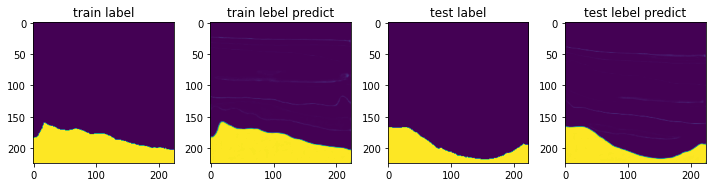

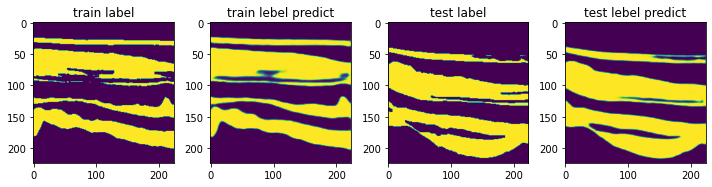

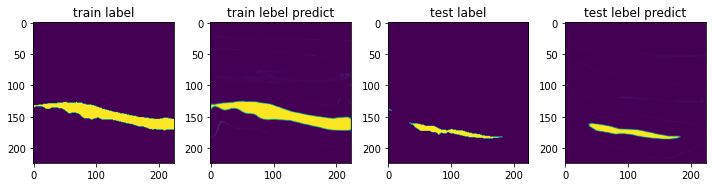

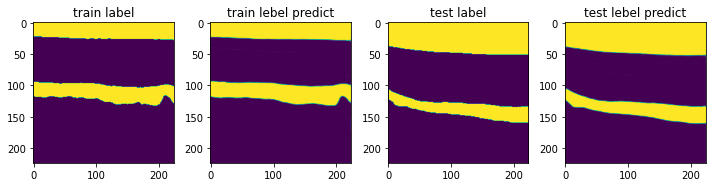

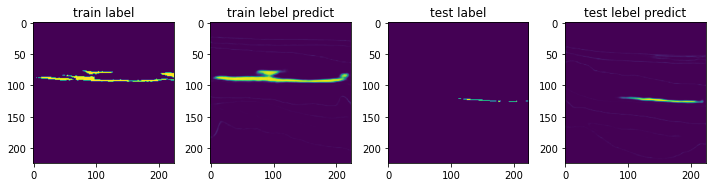

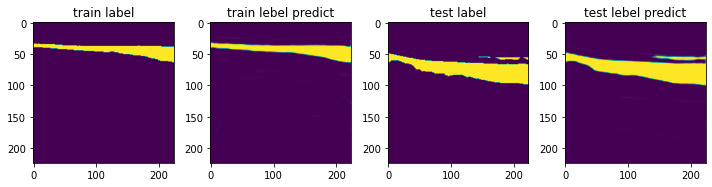

In [18]:
visualize(outimg_tr, tr_lbl, outimg_ts, ts_lbl)

In [67]:
out = np.empty_like(outimg_ts.numpy())
for cls, mask in enumerate(outimg_tr.numpy()):
    mask = np.where(mask > 0.5, 1, 0)
    out[cls,:,:] = (mask * (cls + 1))
    # break

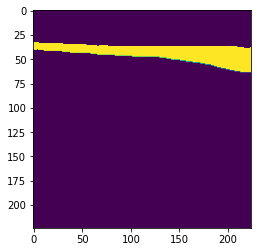

In [68]:
plt.imshow(out[5,...])

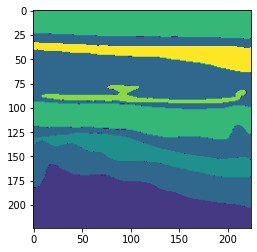

In [70]:
plt.imshow(np.sum(out, axis=0))